In [1]:
# Import Relevant Libraries
import pandas as pd
import os
from pathlib import Path
import openpyxl  # Ensure openpyxl is installed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Union
import time
import logging
import openai

In [2]:
# Load the df_chat_search_filtered.csv file
data_dir = Path('chat_exports')
df_chat_search = pd.read_csv(data_dir / 'df_chat_search_filtered.csv', sep=',')
print(f"df_chat_search shape: {df_chat_search.shape}")
# Preview the dataset
df_chat_search.head()

df_chat_search shape: (143, 11)


,participant_id,prompt,response,logged_at,query_start_time,query_submit_time,query_duration_ms,query_sequence_number,prompt_index,url,clicked_at
0,090b95b5-f52a-4e45-8665-1cc819388638,What is a realistic phone when it comes to cos...,A realistic phone with the best cost-to-qualit...,2025-11-07 15:08:07.503559+00,2025-11-07 15:05:33.382+00,2025-11-07 15:07:50.895000+00:00,137513.0,1,NaN,NaN,NaN
1,0ba4f0a8-673f-4054-80e0-690aaf497b51,What phones are currently available on the mar...,Several **excellent budget and mid-range smart...,2025-11-11 03:09:30.955579+00,2025-11-11 03:08:53.203+00,2025-11-11 03:09:17.501000+00:00,24298.0,1,NaN,NaN,NaN
2,0ba4f0a8-673f-4054-80e0-690aaf497b51,give me prices in euros,"To provide **prices in euros**, you need to co...",2025-11-11 03:16:25.604953+00,2025-11-11 03:16:17.415+00,2025-11-11 03:16:19.917000+00:00,2502.0,5,NaN,NaN,NaN
3,0ba4f0a8-673f-4054-80e0-690aaf497b51,give the lowest price you can find for the app...,"The **lowest price for a new, unlocked Apple i...",2025-11-11 03:14:46.851105+00,2025-11-11 03:14:19.384+00,2025-11-11 03:14:40.420000+00:00,21036.0,4,4.0,https://www.apple.com/shop/buy-iphone/iphone-1...,2025-11-11 03:17:08.006738+00
4,0ba4f0a8-673f-4054-80e0-690aaf497b51,"no, i mean tell me about (for the phones you m...",Based on the latest expert rankings and review...,2025-11-11 03:12:34.977885+00,2025-11-11 03:11:37.266+00,2025-11-11 03:12:16.250000+00:00,38984.0,3,NaN,NaN,NaN


In [3]:
# Define the 5 label options (global)
label_options = {
    0: "Broad / exploratory",
    1: "Price-constraints",
    2: "Feature-focused",
    3: "Brand/model comparisons",
    4: "Meta / strategy / explanation"
}
print("Defined label_options:", label_options)

Defined label_options: {0: 'Broad / exploratory', 1: 'Price-constraints', 2: 'Feature-focused', 3: 'Brand/model comparisons', 4: 'Meta / strategy / explanation'}


## Multi-Label Classification for Conversational Prompts

In [6]:
# Multi-Label Classification: Regex-based pattern detection
import re
from typing import List, Set
from collections import defaultdict
import itertools

def label_prompt_multi(text: str) -> List[int]:
    """
    Apply multi-label classification to a conversational search prompt.
    Returns a list of label IDs (0-4) that apply to the prompt.
    A prompt can receive multiple labels if it contains indicators for multiple themes.
    
    Label categories:
        0: Broad / exploratory
        1: Price-constraints
        2: Feature-focused
        3: Brand/model comparisons
        4: Meta / strategy / explanation
    """
    text = str(text).lower()
    matched_labels = set()
    
    # Category 0: Broad / exploratory
    broad_patterns = [
        r'\b(best|top|good|great|recommend|popular|latest|new)\b',
        r'\b(smartphone|phone|mobile|device)\b(?!.*\b(vs|versus|compare)\b)',
        r'^(what|which).*\b(phone|smartphone)',
        r'\b(overall|general|any suggestion)',
    ]
    if any(re.search(pattern, text) for pattern in broad_patterns):
        # Only add broad if no other specific categories match
        matched_labels.add(0)
    
    # Category 1: Price-constraints
    price_patterns = [
        r'\b(price|cost|budget|cheap|affordable|expensive|euro|dollar|usd|eur)\b',
        r'\b(under|within|below|less than|max|maximum)\s*\d+',
        r'\$\d+|€\d+|£\d+|\d+\s*(euro|dollar|pounds)',
        r'\b(how much|price range|in my budget|best value|worth|money)',
        r'\b(low.?cost|mid.?range|entry.?level|flagship)',
    ]
    if any(re.search(pattern, text) for pattern in price_patterns):
        matched_labels.add(1)
    
    # Category 2: Feature-focused
    feature_patterns = [
        r'\b(camera|photo|picture|video|lens|megapixel|mp)\b',
        r'\b(battery|charge|charging|mah|power|fast.?charg)',
        r'\b(screen|display|amoled|oled|lcd|refresh.?rate|hz)\b',
        r'\b(storage|memory|ram|gb|internal|external|space)\b',
        r'\b(processor|cpu|chip|snapdragon|mediatek|performance|speed)\b',
        r'\b(5g|4g|lte|wifi|wireless|connectivity)\b',
        r'\b(feature|spec|specification|capability|quality)\b',
        r'\b(gaming|game|fps|graphics)\b',
        r'\b(waterproof|water.?resistant|ip\d+|durability)\b',
        r'\b(design|build|material|glass|metal|plastic)\b',
    ]
    if any(re.search(pattern, text) for pattern in feature_patterns):
        matched_labels.add(2)
    
    # Category 3: Brand/model comparisons
    comparison_patterns = [
        r'\b(compare|comparison|versus|vs\.?|compared to)\b',
        r'\b(which is better|should i (get|buy|choose|pick))\b',
        r'\b(or|between).*\b(phone|smartphone|model)',
        r'\b(difference|differ)\b.*\b(between|from)',
        r'\b(samsung|apple|iphone|pixel|google|xiaomi|oneplus|oppo|huawei|motorola)\b.*\b(vs|or|versus)',
        r'\b(galaxy|iphone|pixel|redmi|poco|realme)\s+\w+\s+(vs|or|versus)',
        r'\b(model|brand|phone).*\b(better|best|prefer|choose)',
    ]
    if any(re.search(pattern, text) for pattern in comparison_patterns):
        matched_labels.add(3)
    
    # Category 4: Meta / strategy / explanation
    meta_patterns = [
        r'\b(how (do i|to|can i|should i)|what (should|is the best way|do i need))\b',
        r'\b(why|explain|tell me|help me understand)\b',
        r'\b(guide|advice|recommendation|suggestion|tips|tutorial)\b',
        r'\b(looking for|searching for|need help|not sure|confused|don\'t know)\b',
        r'\b(decide|decision|choosing|which one|help.*choose)\b',
        r'\b(learn|understand|know more|information about)\b',
        r'\b(worth it|should i|is it good)\b',
    ]
    if any(re.search(pattern, text) for pattern in meta_patterns):
        matched_labels.add(4)
    
    # If prompt is very broad and no other categories matched, keep broad
    # If other categories matched, remove broad unless it's explicitly exploratory
    if len(matched_labels) > 1 and 0 in matched_labels:
        # Remove broad if other specific categories are present
        # unless there are explicit broad terms like "overall" or "general"
        if not re.search(r'\b(overall|general|any|what are|which are)\b', text):
            matched_labels.discard(0)
    
    # Return sorted list (or [0] as default if nothing matched)
    return sorted(list(matched_labels)) if matched_labels else [0]

# Test the function with example prompts
print("Testing multi-label classification:\n")
test_prompts = [
    "What's the best smartphone under 500 euros with good camera?",
    "Samsung Galaxy S23 vs iPhone 14 Pro",
    "How do I choose a phone with good battery life?",
    "Cheap phones with 5G",
    "Best camera phones"
]

for prompt in test_prompts:
    labels = label_prompt_multi(prompt)
    label_names = [label_options[lid] for lid in labels]
    print(f"Prompt: {prompt}")
    print(f"  Labels: {labels} → {', '.join(label_names)}\n")

Testing multi-label classification:

Prompt: What's the best smartphone under 500 euros with good camera?
  Labels: [1, 2] → Price-constraints, Feature-focused

Prompt: Samsung Galaxy S23 vs iPhone 14 Pro
  Labels: [3] → Brand/model comparisons

Prompt: How do I choose a phone with good battery life?
  Labels: [2, 4] → Feature-focused, Meta / strategy / explanation

Prompt: Cheap phones with 5G
  Labels: [1, 2] → Price-constraints, Feature-focused

Prompt: Best camera phones
  Labels: [2] → Feature-focused



In [7]:
# Apply multi-label classification to the entire dataset
print("Applying multi-label classification to all prompts...")
print(f"Processing {len(df_chat_search)} prompts...\n")

# Apply the function to each prompt
df_chat_search['multi_labels'] = df_chat_search['prompt'].apply(label_prompt_multi)

# Create binary indicator columns for each label
for lid, label_name in label_options.items():
    col_name = f"label_{lid}_{label_name.replace(' / ', '_').replace(' ', '_').lower()}"
    df_chat_search[col_name] = df_chat_search['multi_labels'].apply(lambda x: 1 if lid in x else 0)

print("Multi-label classification complete!")
print(f"\nSample results:")
print(df_chat_search[['prompt', 'multi_labels']].head(10))

Applying multi-label classification to all prompts...
Processing 143 prompts...

Multi-label classification complete!

Sample results:
                                              prompt     multi_labels
0  What is a realistic phone when it comes to cos...           [1, 2]
1  What phones are currently available on the mar...              [1]
2                            give me prices in euros              [0]
3  give the lowest price you can find for the app...              [1]
4  no, i mean tell me about (for the phones you m...  [0, 1, 2, 3, 4]
5  tell me about: Brand and model Storage capacit...        [1, 2, 4]
6  between these models: Xiaomi Poco X7 Pro, Xiao...        [2, 3, 4]
7           give me a link to buy Xiaomi Poco X7 Pro              [0]
8  give me smartphone models with a price below 2...           [1, 2]
9  give me the technical details for Xiaomi Poco ...              [0]


In [9]:
# Statistical Analysis: Label Distribution
print("=" * 70)
print("MULTI-LABEL CLASSIFICATION STATISTICS")
print("=" * 70)

# 1. Distribution of individual labels
print("\n1. LABEL DISTRIBUTION (count and percentage)")
print("-" * 70)
label_counts = {}
total_prompts = len(df_chat_search)

for lid, label_name in label_options.items():
    col_name = f"label_{lid}_{label_name.replace(' / ', '_').replace(' ', '_').lower()}"
    count = df_chat_search[col_name].sum()
    percentage = (count / total_prompts) * 100
    label_counts[lid] = count
    print(f"  [{lid}] {label_name:35s}: {count:5d} ({percentage:5.1f}%)")

# 2. Average number of labels per prompt
print("\n2. LABELS PER PROMPT")
print("-" * 70)
label_counts_per_prompt = df_chat_search['multi_labels'].apply(len)
avg_labels = label_counts_per_prompt.mean()
min_labels = label_counts_per_prompt.min()
max_labels = label_counts_per_prompt.max()

print(f"  Average labels per prompt: {avg_labels:.2f}")
print(f"  Min labels per prompt: {min_labels}")
print(f"  Max labels per prompt: {max_labels}")
print(f"\n  Distribution of label counts:")
for num_labels in sorted(label_counts_per_prompt.unique()):
    count = (label_counts_per_prompt == num_labels).sum()
    percentage = (count / total_prompts) * 100
    print(f"    {num_labels} label(s): {count:5d} prompts ({percentage:5.1f}%)")

# 3. Most common label combinations
print("\n3. TOP 10 LABEL COMBINATIONS")
print("-" * 70)
label_combinations = df_chat_search['multi_labels'].apply(tuple).value_counts()
print(f"  Total unique combinations: {len(label_combinations)}\n")
for combo, count in label_combinations.head(10).items():
    label_names = [label_options[lid] for lid in combo]
    percentage = (count / total_prompts) * 100
    print(f"  {str(list(combo)):<20s} → {count:5d} ({percentage:5.1f}%)")
    print(f"    {' + '.join(label_names)}")
    print()

MULTI-LABEL CLASSIFICATION STATISTICS

1. LABEL DISTRIBUTION (count and percentage)
----------------------------------------------------------------------
  [0] Broad / exploratory                :    56 ( 39.2%)
  [1] Price-constraints                  :    57 ( 39.9%)
  [2] Feature-focused                    :    35 ( 24.5%)
  [3] Brand/model comparisons            :    19 ( 13.3%)
  [4] Meta / strategy / explanation      :    15 ( 10.5%)

2. LABELS PER PROMPT
----------------------------------------------------------------------
  Average labels per prompt: 1.27
  Min labels per prompt: 1
  Max labels per prompt: 5

  Distribution of label counts:
    1 label(s):   114 prompts ( 79.7%)
    2 label(s):    21 prompts ( 14.7%)
    3 label(s):     7 prompts (  4.9%)
    5 label(s):     1 prompts (  0.7%)

3. TOP 10 LABEL COMBINATIONS
----------------------------------------------------------------------
  Total unique combinations: 18

  [0]                  →    51 ( 35.7%)
    Broad /

In [10]:
# 4. Co-occurrence Matrix: How often labels appear together
print("\n4. LABEL CO-OCCURRENCE MATRIX")
print("-" * 70)
print("Shows how often each pair of labels appears together in prompts\n")

# Build co-occurrence matrix
n_labels = len(label_options)
cooccurrence_matrix = np.zeros((n_labels, n_labels), dtype=int)

for labels in df_chat_search['multi_labels']:
    # For each pair of labels in this prompt
    for i, j in itertools.combinations(labels, 2):
        cooccurrence_matrix[i, j] += 1
        cooccurrence_matrix[j, i] += 1  # Symmetric matrix
    # Diagonal: count how many times each label appears alone or with others
    for label in labels:
        cooccurrence_matrix[label, label] += 1

# Create DataFrame for better visualization
cooccurrence_df = pd.DataFrame(
    cooccurrence_matrix,
    index=[f"[{i}] {label_options[i][:20]}" for i in range(n_labels)],
    columns=[f"[{i}] {label_options[i][:20]}" for i in range(n_labels)]
)

print(cooccurrence_df)
print("\nNote: Diagonal shows total occurrences of each label.")
print("      Off-diagonal shows how many prompts contain both labels.")

# Find most frequent co-occurrences (excluding diagonal)
print("\n5. TOP LABEL PAIRS (Co-occurring labels)")
print("-" * 70)
cooccurrences = []
for i in range(n_labels):
    for j in range(i+1, n_labels):
        count = cooccurrence_matrix[i, j]
        if count > 0:
            cooccurrences.append((i, j, count))

cooccurrences.sort(key=lambda x: x[2], reverse=True)

for i, j, count in cooccurrences[:10]:
    percentage = (count / total_prompts) * 100
    print(f"  [{i}] {label_options[i]} + [{j}] {label_options[j]}")
    print(f"    {count:5d} prompts ({percentage:5.1f}%)\n")


4. LABEL CO-OCCURRENCE MATRIX
----------------------------------------------------------------------
Shows how often each pair of labels appears together in prompts

                          [0] Broad / exploratory  [1] Price-constraints  \
[0] Broad / exploratory                        56                      4   
[1] Price-constraints                           4                     57   
[2] Feature-focused                             3                     14   
[3] Brand/model comparis                        1                      6   
[4] Meta / strategy / ex                        1                      6   

                          [2] Feature-focused  [3] Brand/model comparis  \
[0] Broad / exploratory                     3                         1   
[1] Price-constraints                      14                         6   
[2] Feature-focused                        35                         6   
[3] Brand/model comparis                    6                        19   
[


6. VISUALIZATION: Label Co-occurrence Heatmap
----------------------------------------------------------------------


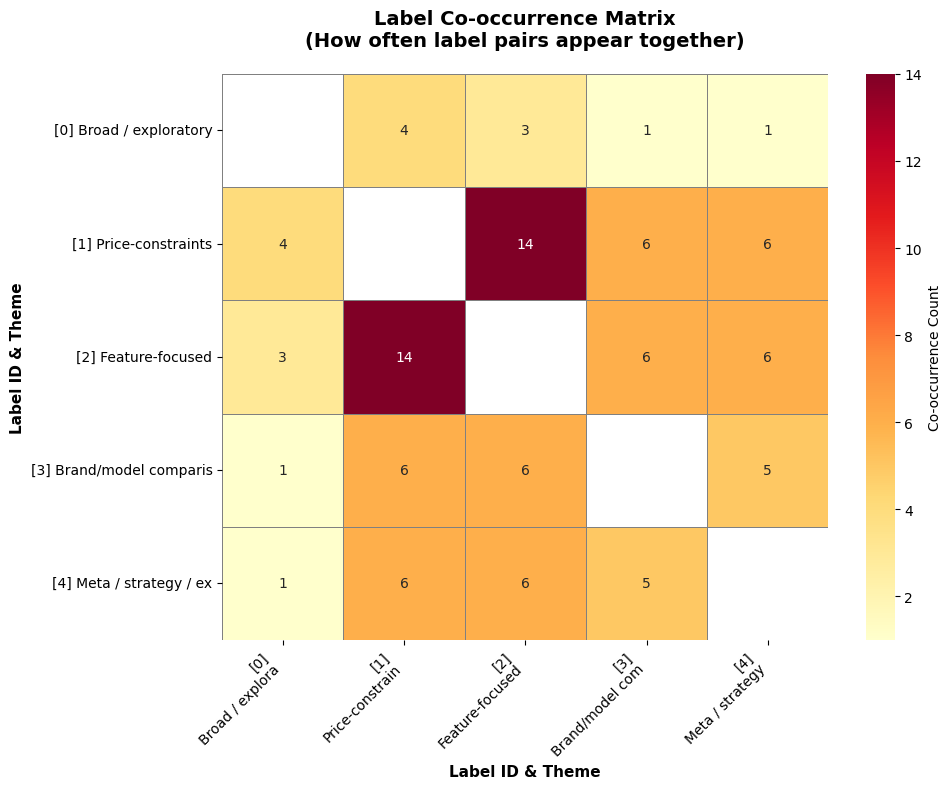


Note: Darker colors indicate more frequent co-occurrence.
      Diagonal values (self-occurrence) are hidden for clarity.


In [11]:
# Visualize the co-occurrence matrix as a heatmap
print("\n6. VISUALIZATION: Label Co-occurrence Heatmap")
print("-" * 70)

plt.figure(figsize=(10, 8))

# Create a copy for visualization (set diagonal to NaN for better color scale)
cooccurrence_viz = cooccurrence_matrix.copy().astype(float)
np.fill_diagonal(cooccurrence_viz, np.nan)

# Create heatmap
sns.heatmap(
    cooccurrence_viz,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    xticklabels=[f"[{i}]\n{label_options[i][:15]}" for i in range(n_labels)],
    yticklabels=[f"[{i}] {label_options[i][:20]}" for i in range(n_labels)],
    cbar_kws={'label': 'Co-occurrence Count'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Label Co-occurrence Matrix\n(How often label pairs appear together)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Label ID & Theme', fontsize=11, fontweight='bold')
plt.ylabel('Label ID & Theme', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nNote: Darker colors indicate more frequent co-occurrence.")
print("      Diagonal values (self-occurrence) are hidden for clarity.")


7. VISUALIZATION: Label Distribution
----------------------------------------------------------------------


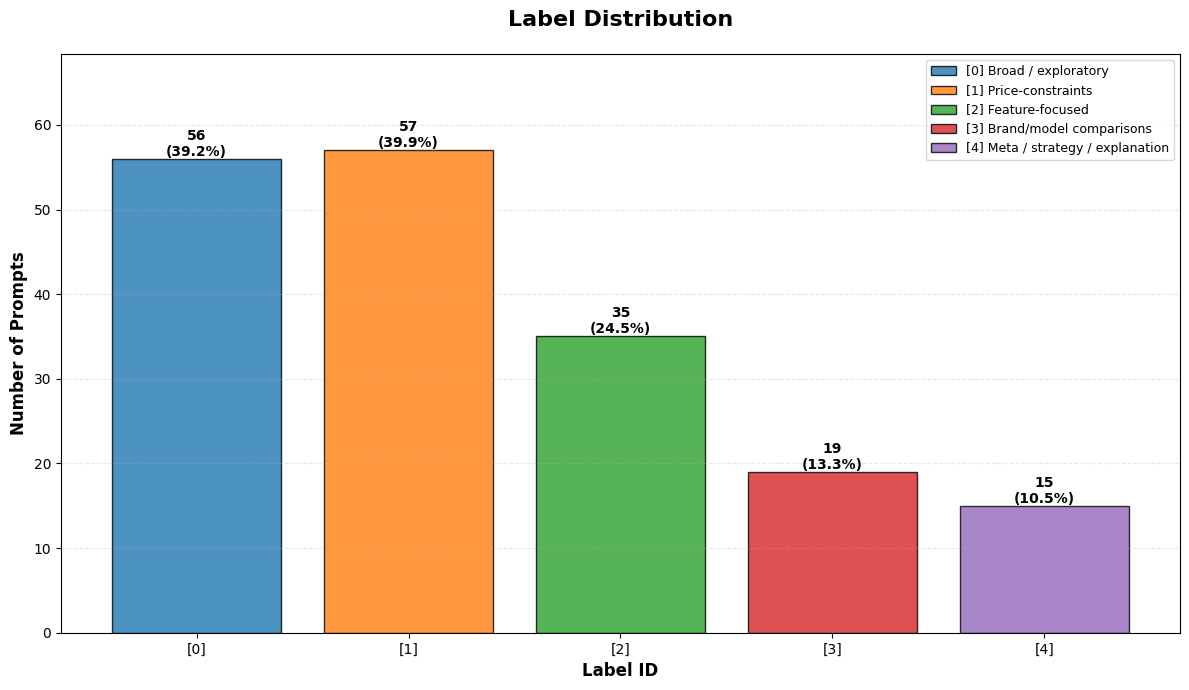

Total prompts analyzed: 143


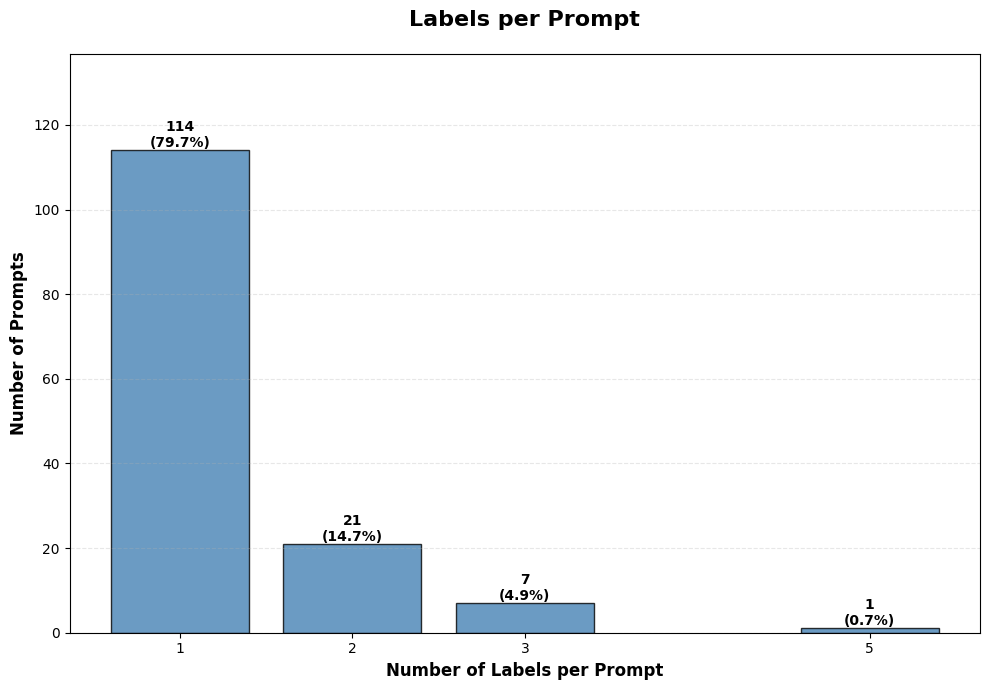

Average labels per prompt: 1.27


In [20]:
# Additional visualization: Label distribution bar chart
print("\n7. VISUALIZATION: Label Distribution")
print("-" * 70)

# Prepare data
label_names_short = [label_options[i] for i in range(n_labels)]
counts = [label_counts[i] for i in range(n_labels)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
label_count_dist = label_counts_per_prompt.value_counts().sort_index()

# First plot: Absolute counts
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(range(n_labels), counts, color=colors, alpha=0.8, edgecolor='black')
ax.set_xlabel('Label ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Prompts', fontsize=12, fontweight='bold')
ax.set_title('Label Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(n_labels))
ax.set_xticklabels([f"[{i}]" for i in range(n_labels)], fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (count, color) in enumerate(zip(counts, colors)):
    percentage = (count / total_prompts) * 100
    ax.text(i, count, f'{count}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legend with label names
legend_labels = [f"[{i}] {label_options[i]}" for i in range(n_labels)]
ax.legend(bars, legend_labels, loc='upper right', fontsize=9, frameon=True)

# Set y-axis limit to create space for annotations
ax.set_ylim(0, max(counts) * 1.20)

plt.tight_layout()
plt.show()

print(f"Total prompts analyzed: {total_prompts}")

# Second plot: Number of labels per prompt
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(label_count_dist.index, label_count_dist.values, 
       color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Labels per Prompt', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Prompts', fontsize=12, fontweight='bold')
ax.set_title('Labels per Prompt', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(label_count_dist.index)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for idx, count in zip(label_count_dist.index, label_count_dist.values):
    percentage = (count / total_prompts) * 100
    ax.text(idx, count, f'{count}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set y-axis limit to create space for annotations
ax.set_ylim(0, max(label_count_dist.values) * 1.20)

plt.tight_layout()
plt.show()

print(f"Average labels per prompt: {avg_labels:.2f}")

In [22]:
# Export results to CSV
print("\n8. EXPORTING RESULTS")
print("-" * 70)

# Create export dataframe with relevant columns
export_cols = ['prompt', 'multi_labels']
for lid in range(n_labels):
    col_name = f"label_{lid}_{label_options[lid].replace(' / ', '_').replace(' ', '_').lower()}"
    export_cols.append(col_name)

df_export = df_chat_search[export_cols].copy()

# Add label names as a readable column
df_export['label_names'] = df_export['multi_labels'].apply(
    lambda x: ' | '.join([label_options[lid] for lid in x])
)

# Create output directory if it doesn't exist
output_dir = Path('chat_exports')
output_dir.mkdir(exist_ok=True)

# Save to CSV
output_file = output_dir / 'multilabel_classification_results.csv'
df_export.to_csv(output_file, index=False)
print(f"✓ Saved results to: {output_file}")
print(f"  Columns: {len(df_export.columns)}")
print(f"  Rows: {len(df_export)}")

# Save summary statistics
summary_file = output_dir / 'multilabel_classification_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("=" * 70 + "\n")
    f.write("MULTI-LABEL CLASSIFICATION SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("1. LABEL DISTRIBUTION\n")
    f.write("-" * 70 + "\n")
    for lid, label_name in label_options.items():
        count = label_counts[lid]
        percentage = (count / total_prompts) * 100
        f.write(f"  [{lid}] {label_name:35s}: {count:5d} ({percentage:5.1f}%)\n")
    
    f.write("\n2. LABELS PER PROMPT\n")
    f.write("-" * 70 + "\n")
    f.write(f"  Average: {avg_labels:.2f}\n")
    f.write(f"  Min: {min_labels}\n")
    f.write(f"  Max: {max_labels}\n\n")
    
    f.write("3. TOP 10 LABEL COMBINATIONS\n")
    f.write("-" * 70 + "\n")
    for combo, count in label_combinations.head(10).items():
        label_names = [label_options[lid] for lid in combo]
        percentage = (count / total_prompts) * 100
        f.write(f"  {str(list(combo)):<20s} → {count:5d} ({percentage:5.1f}%)\n")
        f.write(f"    {' + '.join(label_names)}\n\n")

print(f"✓ Saved summary to: {summary_file}")
print("\n" + "=" * 70)
print("Multi-label classification complete!")
print("=" * 70)


8. EXPORTING RESULTS
----------------------------------------------------------------------
✓ Saved results to: chat_exports\multilabel_classification_results.csv
  Columns: 8
  Rows: 143
✓ Saved summary to: chat_exports\multilabel_classification_summary.txt

Multi-label classification complete!


## Markov Chain Analysis: Prompt Intent Transitions

Analyze how users transition between different prompt intents throughout their search sessions.

In [23]:
# Step 1: Prepare data with single-label classification for Markov analysis
print("=" * 70)
print("MARKOV CHAIN ANALYSIS: QUERY INTENT TRANSITIONS")
print("=" * 70)

def label_prompt_single(text: str) -> int:
    """
    Apply single-label classification to a conversational search prompt.
    Returns the most dominant label ID (0-4) for Markov chain analysis.
    
    Priority order: 3 (Brand/model) > 1 (Price) > 2 (Features) > 4 (Meta) > 0 (Broad)
    """
    text = str(text).lower()
    
    # Category 3: Brand/model comparisons (highest priority - most specific)
    comparison_patterns = [
        r'\b(compare|comparison|versus|vs\.?|compared to)\b',
        r'\b(which is better|should i (get|buy|choose|pick))\b',
        r'\b(or|between).*\b(phone|smartphone|model)',
        r'\b(difference|differ)\b.*\b(between|from)',
        r'\b(samsung|apple|iphone|pixel|google|xiaomi|oneplus|oppo|huawei|motorola)\b.*\b(vs|or|versus)',
        r'\b(galaxy|iphone|pixel|redmi|poco|realme)\s+\w+\s+(vs|or|versus)',
        r'\b(model|brand|phone).*\b(better|best|prefer|choose)',
    ]
    if any(re.search(pattern, text) for pattern in comparison_patterns):
        return 3
    
    # Category 1: Price-constraints
    price_patterns = [
        r'\b(price|cost|budget|cheap|affordable|expensive|euro|dollar|usd|eur)\b',
        r'\b(under|within|below|less than|max|maximum)\s*\d+',
        r'\$\d+|€\d+|£\d+|\d+\s*(euro|dollar|pounds)',
        r'\b(how much|price range|in my budget|best value|worth|money)',
        r'\b(low.?cost|mid.?range|entry.?level|flagship)',
    ]
    if any(re.search(pattern, text) for pattern in price_patterns):
        return 1
    
    # Category 2: Feature-focused
    feature_patterns = [
        r'\b(camera|photo|picture|video|lens|megapixel|mp)\b',
        r'\b(battery|charge|charging|mah|power|fast.?charg)',
        r'\b(screen|display|amoled|oled|lcd|refresh.?rate|hz)\b',
        r'\b(storage|memory|ram|gb|internal|external|space)\b',
        r'\b(processor|cpu|chip|snapdragon|mediatek|performance|speed)\b',
        r'\b(5g|4g|lte|wifi|wireless|connectivity)\b',
        r'\b(feature|spec|specification|capability|quality)\b',
        r'\b(gaming|game|fps|graphics)\b',
        r'\b(waterproof|water.?resistant|ip\d+|durability)\b',
        r'\b(design|build|material|glass|metal|plastic)\b',
    ]
    if any(re.search(pattern, text) for pattern in feature_patterns):
        return 2
    
    # Category 4: Meta / strategy / explanation
    meta_patterns = [
        r'\b(how (do i|to|can i|should i)|what (should|is the best way|do i need))\b',
        r'\b(why|explain|tell me|help me understand)\b',
        r'\b(guide|advice|recommendation|suggestion|tips|tutorial)\b',
        r'\b(looking for|searching for|need help|not sure|confused|don\'t know)\b',
        r'\b(decide|decision|choosing|which one|help.*choose)\b',
        r'\b(learn|understand|know more|information about)\b',
        r'\b(worth it|should i|is it good)\b',
    ]
    if any(re.search(pattern, text) for pattern in meta_patterns):
        return 4
    
    # Category 0: Broad / exploratory (default)
    return 0

# Apply single-label classification
print("\n1. Applying single-label classification for Markov analysis...")
df_chat_search['intent_label'] = df_chat_search['prompt'].apply(label_prompt_single)

# Create intent_name column
df_chat_search['intent_name'] = df_chat_search['intent_label'].map(label_options)

print("✓ Classification complete!")
print(f"\nIntent distribution:")
print(df_chat_search['intent_label'].value_counts().sort_index())

MARKOV CHAIN ANALYSIS: QUERY INTENT TRANSITIONS

1. Applying single-label classification for Markov analysis...
✓ Classification complete!

Intent distribution:
intent_label
0    51
1    51
2    18
3    19
4     4
Name: count, dtype: int64


In [24]:
# Step 2: Build transition sequences for each participant
print("\n2. Building transition sequences...")

# Sort by participant and query sequence
df_sorted = df_chat_search.sort_values(['participant_id', 'query_sequence_number'])

# Build transitions
transitions = []
for participant_id, group in df_sorted.groupby('participant_id'):
    group = group.sort_values('query_sequence_number')
    intents = group['intent_label'].tolist()
    
    # Create transitions (from one query to the next)
    for i in range(len(intents) - 1):
        transitions.append({
            'from_intent': intents[i],
            'to_intent': intents[i + 1],
            'participant_id': participant_id
        })

transitions_df = pd.DataFrame(transitions)
print(f"✓ Found {len(transitions_df)} transitions across {df_sorted['participant_id'].nunique()} participants")

# Step 3: Calculate transition counts and probabilities
print("\n3. Calculating transition matrix...")

# Create transition count matrix
trans_counts = pd.crosstab(transitions_df['from_intent'], transitions_df['to_intent'])

# Ensure all intents are represented (5x5 matrix)
all_intents = [0, 1, 2, 3, 4]
trans_counts_full = trans_counts.reindex(index=all_intents, columns=all_intents, fill_value=0)

# Calculate probabilities (row-wise normalization)
trans_probs_full = trans_counts_full.div(trans_counts_full.sum(axis=1), axis=0).fillna(0)

# Add intent names for better readability
intent_names_short = {
    0: "Broad/exploratory",
    1: "Price-focused",
    2: "Feature-focused",
    3: "Brand/model",
    4: "Meta/strategy"
}

trans_probs_named = trans_probs_full.copy()
trans_probs_named.index = [intent_names_short[i] for i in trans_probs_full.index]
trans_probs_named.columns = [intent_names_short[i] for i in trans_probs_full.columns]

print("\nTransition Probability Matrix:")
print(trans_probs_named.round(3))

# Calculate starting and ending intents
print("\n4. Analyzing session patterns...")
first_queries = df_sorted.groupby('participant_id').first()
last_queries = df_sorted.groupby('participant_id').last()

starting_intents = first_queries['intent_label'].value_counts(normalize=True).sort_index()
ending_intents = last_queries['intent_label'].value_counts(normalize=True).sort_index()

print("\nStarting Intent (first query of each session):")
for idx in all_intents:
    if idx in starting_intents.index:
        print(f"  [{idx}] {label_options[idx]:35s}: {starting_intents[idx]*100:5.1f}%")

print("\nEnding Intent (last query of each session):")
for idx in all_intents:
    if idx in ending_intents.index:
        print(f"  [{idx}] {label_options[idx]:35s}: {ending_intents[idx]*100:5.1f}%")


2. Building transition sequences...
✓ Found 98 transitions across 45 participants

3. Calculating transition matrix...

Transition Probability Matrix:
                   Broad/exploratory  Price-focused  Feature-focused  \
Broad/exploratory              0.500          0.267            0.133   
Price-focused                  0.361          0.389            0.083   
Feature-focused                0.133          0.333            0.267   
Brand/model                    0.231          0.385            0.077   
Meta/strategy                  0.750          0.250            0.000   

                   Brand/model  Meta/strategy  
Broad/exploratory        0.033          0.067  
Price-focused            0.139          0.028  
Feature-focused          0.267          0.000  
Brand/model              0.231          0.077  
Meta/strategy            0.000          0.000  

4. Analyzing session patterns...

Starting Intent (first query of each session):
  [0] Broad / exploratory                :  3


5. Creating Markov Chain visualization...


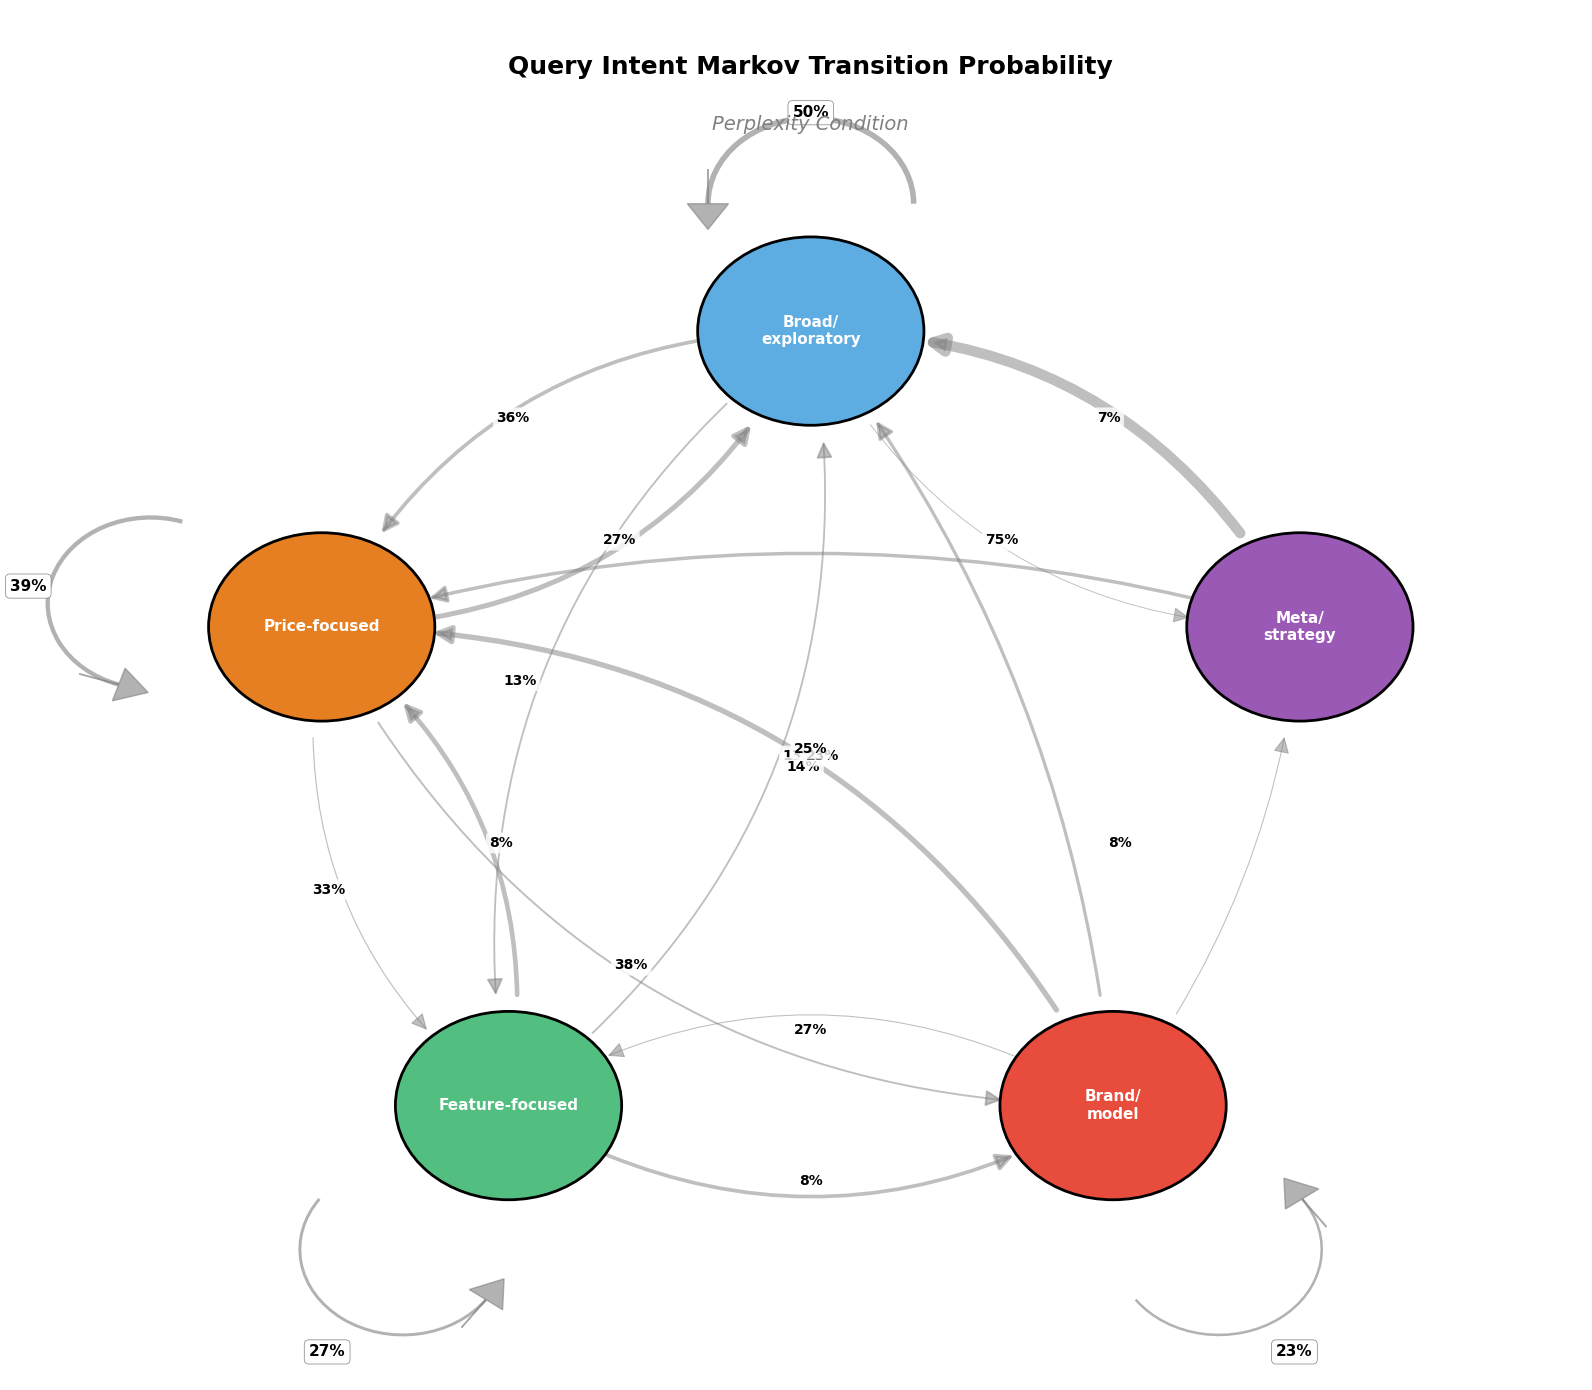


✓ Markov chain visualization complete!


In [ ]:
# Step 5: Visualize Markov Chain as Network Diagram
print("\n5. Creating Markov Chain visualization...")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch, Circle, Arc
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

# Define colors for each intent (matching the screenshot style)
intent_colors = {
    0: '#5DADE2',  # Blue - Broad/exploratory
    1: '#E67E22',  # Orange - Price-focused
    2: '#52BE80',  # Green - Feature-focused
    3: '#E74C3C',  # Red - Brand/model
    4: '#9B59B6'   # Purple - Meta/strategy
}

# Position nodes in a circle
n_nodes = 5
angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
# Rotate to have node 0 at top
angles = angles + np.pi/2

node_positions = {}
for i, angle in enumerate(angles):
    node_positions[i] = (np.cos(angle), np.sin(angle))

# Draw edges (transitions) - NOTE: Arrow goes FROM from_pos TO to_pos
for from_intent in range(5):
    for to_intent in range(5):
        prob = trans_probs_full.iloc[from_intent, to_intent]
        
        if prob < 0.05:  # Skip very weak transitions
            continue
        
        from_pos = node_positions[from_intent]
        to_pos = node_positions[to_intent]
        
        # Self-loop
        if from_intent == to_intent:
            # Draw circular self-loop
            loop_radius = 0.18
            # Position the loop outside the node
            angle = angles[from_intent]
            loop_center_x = from_pos[0] * 1.4
            loop_center_y = from_pos[1] * 1.4
            
            # Draw circle for self-loop
            self_loop = Circle((loop_center_x, loop_center_y), loop_radius,
                              edgecolor='gray',
                              facecolor='none',
                              linewidth=prob * 8,
                              alpha=0.6)
            ax.add_patch(self_loop)
            
            # Add probability label outside the loop
            label_x = from_pos[0] * 1.65
            label_y = from_pos[1] * 1.65
            ax.text(label_x, label_y, f'{prob*100:.0f}%',
                   fontsize=11, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor='gray', linewidth=0.5))
        else:
            # Draw arrow between different nodes
            # IMPORTANT: Arrow points FROM from_pos TO to_pos
            # This matches the matrix: row (from) -> column (to)
            
            # Use curved arrows
            connectionstyle = f"arc3,rad=0.2"
            
            arrow = FancyArrowPatch(
                from_pos, to_pos,  # Arrow direction: from_pos -> to_pos
                arrowstyle='-|>',
                mutation_scale=25,
                linewidth=prob * 10,
                color='gray',
                alpha=0.5,
                connectionstyle=connectionstyle,
                shrinkA=80, shrinkB=80
            )
            ax.add_patch(arrow)
            
            # Add probability label at midpoint
            mid_x = (from_pos[0] + to_pos[0]) / 2
            mid_y = (from_pos[1] + to_pos[1]) / 2
            
            # Offset label perpendicular to arrow
            dx = to_pos[0] - from_pos[0]
            dy = to_pos[1] - from_pos[1]
            perp_x = -dy * 0.15
            perp_y = dx * 0.15
            
            ax.text(mid_x + perp_x, mid_y + perp_y, f'{prob*100:.0f}%',
                   fontsize=10, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.25', facecolor='white', 
                            edgecolor='none', alpha=0.8))

# Draw nodes
node_size = 0.22
for intent, pos in node_positions.items():
    # Draw circle
    circle = Circle(pos, node_size, 
                   color=intent_colors[intent],
                   ec='black', linewidth=2, zorder=10)
    ax.add_patch(circle)
    
    # Add label inside circle
    label_text = intent_names_short[intent].replace('/', '/\n')
    ax.text(pos[0], pos[1], label_text,
           fontsize=11, fontweight='bold',
           ha='center', va='center', zorder=11,
           color='white')

# Add title
ax.text(0, 1.35, 'Query Intent Markov Transition Probability',
       fontsize=18, fontweight='bold', ha='center')
ax.text(0, 1.25, 'Perplexity Condition',
       fontsize=14, ha='center', style='italic', color='gray')

plt.tight_layout()
plt.show()

print("\n✓ Markov chain visualization complete!")

In [26]:
# Step 6: Export Markov transition results
print("\n6. Exporting Markov transition analysis...")

output_dir = Path('chat_exports')

# Export transition probability matrix
trans_prob_file = output_dir / 'markov_transition_probabilities.csv'
trans_probs_named.to_csv(trans_prob_file)
print(f"✓ Saved transition probabilities to: {trans_prob_file}")

# Export transition counts
trans_count_file = output_dir / 'markov_transition_counts.csv'
trans_counts_named = trans_counts_full.copy()
trans_counts_named.index = [intent_names_short[i] for i in trans_counts_full.index]
trans_counts_named.columns = [intent_names_short[i] for i in trans_counts_full.columns]
trans_counts_named.to_csv(trans_count_file)
print(f"✓ Saved transition counts to: {trans_count_file}")

# Export summary statistics
summary_file = output_dir / 'markov_analysis_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("=" * 70 + "\n")
    f.write("MARKOV CHAIN ANALYSIS SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("1. TRANSITION PROBABILITY MATRIX\n")
    f.write("-" * 70 + "\n")
    f.write(trans_probs_named.round(3).to_string())
    f.write("\n\n")
    
    f.write("2. STARTING INTENT (First query of each session)\n")
    f.write("-" * 70 + "\n")
    for idx in all_intents:
        if idx in starting_intents.index:
            f.write(f"  [{idx}] {label_options[idx]:35s}: {starting_intents[idx]*100:5.1f}%\n")
    
    f.write("\n3. ENDING INTENT (Last query of each session)\n")
    f.write("-" * 70 + "\n")
    for idx in all_intents:
        if idx in ending_intents.index:
            f.write(f"  [{idx}] {label_options[idx]:35s}: {ending_intents[idx]*100:5.1f}%\n")
    
    f.write("\n4. KEY INSIGHTS\n")
    f.write("-" * 70 + "\n")
    
    # Find strongest self-loops
    self_loops = [(i, trans_probs_full.iloc[i, i]) for i in range(5)]
    self_loops.sort(key=lambda x: x[1], reverse=True)
    
    f.write("\nStrongest self-loops (staying in same intent):\n")
    for intent, prob in self_loops[:3]:
        if prob > 0:
            f.write(f"  {intent_names_short[intent]:25s}: {prob*100:.1f}%\n")
    
    # Find strongest transitions (excluding self-loops)
    transitions_list = []
    for i in range(5):
        for j in range(5):
            if i != j and trans_probs_full.iloc[i, j] > 0.05:
                transitions_list.append((i, j, trans_probs_full.iloc[i, j]))
    transitions_list.sort(key=lambda x: x[2], reverse=True)
    
    f.write("\nTop cross-intent transitions:\n")
    for from_i, to_i, prob in transitions_list[:5]:
        f.write(f"  {intent_names_short[from_i]} → {intent_names_short[to_i]}: {prob*100:.1f}%\n")

print(f"✓ Saved summary to: {summary_file}")

print("\n" + "=" * 70)
print("Markov chain analysis complete!")
print("=" * 70)


6. Exporting Markov transition analysis...
✓ Saved transition probabilities to: chat_exports\markov_transition_probabilities.csv
✓ Saved transition counts to: chat_exports\markov_transition_counts.csv
✓ Saved summary to: chat_exports\markov_analysis_summary.txt

Markov chain analysis complete!
